## `Augmented Reality with Planar Homographies`

`importing libraries`

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

`Load Data`

In [3]:
image_path = os.path.join("..", "material", "cv_cover.jpg")
cv_cover = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

In [6]:
def convert_to_grayscale(image):
    """Convert a given image to grayscale."""
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

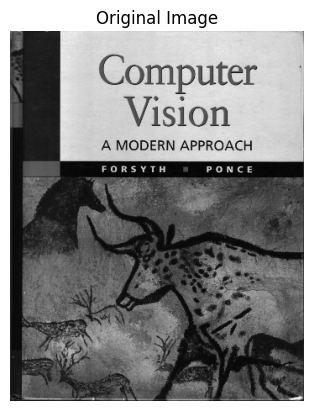

In [4]:
plt.figure()
plt.imshow(cv_cover, cmap='gray')
plt.axis('off')
plt.title("Original Image")


plt.show()

In [8]:
def load_first_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise ValueError("Could not read the first frame from the video.")
    return frame


def load_video_frames(video_path):  

    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames



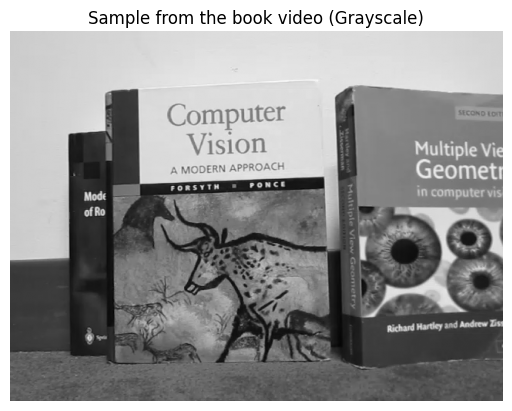

In [9]:
# Load the first frame of the video
video1_path = os.path.join("..", "material", "book.mov")
book_first_frame = load_first_frame(video1_path)

# Convert to grayscale
if book_first_frame is not None:
    book_first_frame_gray = convert_to_grayscale(book_first_frame)

    # Display the grayscale image
    plt.figure()
    plt.imshow(book_first_frame_gray, cmap='gray')
    plt.axis('off')
    plt.title("Sample from the book video (Grayscale)")
    plt.show()
else:
    print("Error: Could not load the first frame of the book video.")


### 1.1 Getting Correspondences